# Tugas Individu: Implementasi Arsitektur Transformer dari Nol

**Nama:** Muhammad Fajrulfalaq Izzulfirdausyah Suryaprabandaru
**NIM:** 22/494174/TK/54184

---

## Deskripsi Tugas

Tugas ini adalah implementasi arsitektur **Decoder-Only Transformer ** dari nol (*from scratch*) menggunakan **NumPy**. Fokus utama adalah membangun alur *forward pass*, mulai dari *embedding* hingga menghasilkan distribusi probabilitas untuk prediksi token berikutnya.

**Aturan Utama:**
* Hanya menggunakan **NumPy** untuk semua operasi matematis.
* Tidak diperbolehkan menggunakan library deep learning seperti PyTorch atau TensorFlow.
* Implementasi dibuat secara **modular**, di mana setiap komponen utama dibuat dalam fungsi atau kelas terpisah.

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed untuk reproduktibilitas (hasil random akan selalu sama)
np.random.seed(42)

print("Library yang dibutuhkan berhasil diimpor.")

Library yang dibutuhkan berhasil diimpor.


## 1. Desain Arsitektur dan Penjelasan Komponen

Arsitektur yang dibangun adalah *decoder-only Transformer*. Model ini dirancang untuk memprediksi token berikutnya dalam sebuah urutan, sehingga sangat cocok untuk tugas-tugas generatif seperti pembuatan teks.

Alur *forward pass* secara garis besar adalah sebagai berikut:
1.  **Input Tokens** diubah menjadi vektor padat melalui **Token Embedding**.
2.  Informasi urutan ditambahkan menggunakan **Positional Encoding**.
3.  Vektor yang dihasilkan kemudian diproses melalui serangkaian **Decoder Blocks** yang identik.
4.  Setiap *Decoder Block* terdiri dari dua sub-lapisan utama:
    * **Masked Multi-Head Self-Attention**.
    * **Position-wise Feed-Forward Network**.
5.  Koneksi residual (*Residual Connection*) dan normalisasi lapisan (*Layer Normalization*) diterapkan di sekitar setiap sub-lapisan untuk menstabilkan dan mempercepat pelatihan.
6.  Terakhir, **Output Layer** memproyeksikan output dari blok decoder terakhir ke dimensi kosakata (*vocabulary size*) dan mengubahnya menjadi distribusi probabilitas menggunakan fungsi *softmax*.

Berikut adalah implementasi detail untuk setiap komponen wajib.

In [46]:
# --- Komponen 1: Token Embedding ---
# Direpresentasikan sebagai sebuah matriks lookup sederhana.
# Bobotnya akan diinisialisasi secara acak.
# Kelas ini hanya untuk ilustrasi, dalam praktiknya kita langsung menggunakan matriks NumPy.
class TokenEmbedding:
    def __init__(self, vocab_size, d_model):
        # Inisialisasi matriks embedding dengan nilai acak
        self.embedding = np.random.randn(vocab_size, d_model)

    def __call__(self, token_indices):
        # Mengambil vektor embedding untuk setiap token dalam input
        return self.embedding[token_indices]

# --- Komponen 2: Positional Encoding ---
# Alasan Pemilihan: Sinusoidal Positional Encoding dipilih karena kemampuannya
# untuk menangani urutan dengan panjang bervariasi dan memberikan representasi
# posisi yang unik untuk setiap token tanpa perlu melatih parameter tambahan.
class PositionalEncoding:
    """Menambahkan informasi posisi ke dalam embedding input."""
    def __init__(self, d_model, max_len=5000):
        # Membuat matriks positional encoding (PE)
        pe = np.zeros((max_len, d_model))
        position = np.arange(0, max_len, dtype=np.float32).reshape(-1, 1)
        # Denominator dari formula (10000^(2i/d_model))
        div_term = np.exp(np.arange(0, d_model, 2).astype(np.float32) * -(np.log(10000.0) / d_model))
        
        # Mengisi nilai pe untuk kolom genap (sin) dan ganjil (cos)
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        
        # Simpan matriks pe
        self.pe = pe

    def __call__(self, x):
        # x memiliki shape: [batch_size, seq_len, d_model]
        # Menambahkan positional encoding ke input x
        return x + self.pe[:x.shape[1], :]

print("Komponen Token Embedding dan Positional Encoding siap.")

Komponen Token Embedding dan Positional Encoding siap.


### Penjelasan Scaled Dot-Product Attention & Causal Masking

**Scaled Dot-Product Attention** adalah inti dari Transformer. Mekanisme ini memungkinkan model untuk menimbang pentingnya token lain saat memproses satu token tertentu. Formulanya adalah:

$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

* **Query (Q)**: Representasi token saat ini, yang digunakan untuk "bertanya" atau mencari token lain yang relevan.
* **Key (K)**: Representasi dari semua token dalam urutan, yang dicocokkan dengan Query.
* **Value (V)**: Representasi dari semua token, yang akan dijumlahkan secara tertimbang berdasarkan skor perhatian untuk menghasilkan output.
* **Scaling ($\sqrt{d_k}$)**: Pembagian dengan akar kuadrat dari dimensi Key dilakukan untuk menstabilkan gradien saat pelatihan.

[**Causal Masking** sangat penting untuk arsitektur *decoder-only*. Tujuannya adalah untuk **mencegah sebuah token mengakses informasi dari token di masa depan**. Saat memprediksi token pada posisi `t`, model hanya boleh melihat token dari posisi `0` hingga `t`. Ini diimplementasikan dengan menambahkan nilai negatif tak hingga (`-inf`) ke skor perhatian untuk semua posisi di masa depan sebelum diterapkan fungsi `softmax`. Setelah `softmax`, skor untuk posisi masa depan akan menjadi 0.

In [47]:
def softmax(x):
    """Menghitung softmax secara stabil."""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Komponen 3: Implementasi Scaled Dot-Product Attention.
    """
    d_k = q.shape[-1]
    # 1. Matmul Q dan K transpose, lalu scaling
    scores = (q @ np.transpose(k, (0, 1, 3, 2))) / np.sqrt(d_k)
    
    # 2. Komponen 7: Terapkan Causal Masking jika ada
    if mask is not None:
        scores += mask  # Menambahkan -inf ke posisi yang di-mask
    
    # 3. Terapkan softmax untuk mendapatkan bobot perhatian
    attention_weights = softmax(scores)
    
    # 4. Matmul bobot dengan V untuk mendapatkan output
    output = attention_weights @ v
    return output, attention_weights

print("Fungsi Scaled Dot-Product Attention siap.")

Fungsi Scaled Dot-Product Attention siap.


In [48]:
class MultiHeadAttention:
    """
    Komponen 4: Implementasi Multi-Head Attention.
    """
    def __init__(self, d_model, n_heads):
        self.n_heads = n_heads
        self.d_model = d_model
        assert d_model % n_heads == 0, "d_model harus bisa dibagi dengan n_heads"
        self.d_k = d_model // n_heads

        # Inisialisasi "weight" (matriks proyeksi) secara acak
        self.W_q = np.random.randn(d_model, d_model)
        self.W_k = np.random.randn(d_model, d_model)
        self.W_v = np.random.randn(d_model, d_model)
        self.W_o = np.random.randn(d_model, d_model)
        
    def __call__(self, q, k, v, mask=None):
        batch_size = q.shape[0]

        # 1. Proyeksi Linear Q, K, V
        q = q @ self.W_q
        k = k @ self.W_k
        v = v @ self.W_v

        # 2. Reshape Q, K, V untuk multi-head
        # Shape: [batch_size, n_heads, seq_len, d_k]
        q = q.reshape(batch_size, -1, self.n_heads, self.d_k).transpose(0, 2, 1, 3)
        k = k.reshape(batch_size, -1, self.n_heads, self.d_k).transpose(0, 2, 1, 3)
        v = v.reshape(batch_size, -1, self.n_heads, self.d_k).transpose(0, 2, 1, 3)

        # 3. Scaled Dot-Product Attention untuk semua head secara paralel
        x, self.attention_weights = scaled_dot_product_attention(q, k, v, mask)

        # 4. Concat hasil dari semua head dan lakukan proyeksi akhir
        x = x.transpose(0, 2, 1, 3).reshape(batch_size, -1, self.d_model)
        output = x @ self.W_o
        return output

print("Komponen Multi-Head Attention siap.")

Komponen Multi-Head Attention siap.


In [49]:
# --- Komponen 5: Feed-Forward Network (FFN) ---
class PositionwiseFeedForward:
    """Implementasi FFN dua lapisan dengan aktivasi non-linear."""
    def __init__(self, d_model, d_ff):
        self.W_1 = np.random.randn(d_model, d_ff)
        self.b_1 = np.zeros(d_ff)
        self.W_2 = np.random.randn(d_ff, d_model)
        self.b_2 = np.zeros(d_model)

    def gelu(self, x):
        """Aktivasi Gaussian Error Linear Unit (GELU)."""
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))
    
    def __call__(self, x):
        # Lapisan pertama dengan aktivasi GELU
        x = self.gelu(x @ self.W_1 + self.b_1)
        # Lapisan kedua (linear)
        x = x @ self.W_2 + self.b_2
        return x

# --- Komponen 6: Layer Normalization (untuk Pre-Norm) ---
class LayerNormalization:
    """Implementasi Layer Normalization."""
    def __init__(self, d_model, eps=1e-5):
        self.eps = eps
        self.gamma = np.ones(d_model)  # parameter scale
        self.beta = np.zeros(d_model)   # parameter shift

    def __call__(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        std = np.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

# --- Komponen 8: Output Layer ---
# Direpresentasikan sebagai proyeksi linear sederhana + softmax.
# Akan digabungkan dalam kelas model utama.

print("Komponen FFN dan Layer Normalization siap.")

Komponen FFN dan Layer Normalization siap.


In [50]:
class DecoderBlock:
    """
    Menggabungkan semua komponen menjadi satu blok Decoder Transformer.
    Struktur Pre-Norm: Norm -> Sublayer -> Add (Residual Connection)
    """
    def __init__(self, d_model, n_heads, d_ff):
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.ln1 = LayerNormalization(d_model)
        self.ln2 = LayerNormalization(d_model)

    def __call__(self, x, mask):
        # Sublayer 1: Masked Multi-Head Attention dengan Residual Connection 
        attn_output = self.mha(self.ln1(x), self.ln1(x), self.ln1(x), mask)
        x = x + attn_output

        # Sublayer 2: Feed-Forward Network dengan Residual Connection 
        ffn_output = self.ffn(self.ln2(x))
        x = x + ffn_output
        return x

class GPTDecoder:
    """
    Arsitektur utama GPT-style Transformer (Decoder-Only).
    """
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, max_len=5000):
        self.embedding = TokenEmbedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.decoder_blocks = [DecoderBlock(d_model, n_heads, d_ff) for _ in range(n_layers)]
        self.ln_final = LayerNormalization(d_model)
        
        # Komponen 8: Output Layer - Proyeksi ke ukuran vocab 
        self.output_projection = np.random.randn(d_model, vocab_size)

    def forward(self, x_tokens):
        batch_size, seq_len = x_tokens.shape
        
        # --- Membuat Causal Mask ---
        # Matriks (seq_len, seq_len) dengan nilai 0 di diagonal bawah dan -inf di atas.
        mask = np.triu(np.full((seq_len, seq_len), -np.inf), k=1)
        
        # 1. Embedding + Positional Encoding
        x = self.embedding(x_tokens)
        x = self.pos_encoder(x)
        
        # 2. Lewatkan ke semua Decoder Blocks
        for block in self.decoder_blocks:
            x = block(x, mask)
            
        # 3. Normalisasi akhir
        x = self.ln_final(x)
        
        # 4. Proyeksi ke ukuran vocab untuk mendapatkan logits 
        logits = x @ self.output_projection
        
        return logits

print("Arsitektur model utama GPTDecoder siap.")

Arsitektur model utama GPTDecoder siap.


## 2. Uji Coba Sederhana & Bukti Uji

Bagian ini berisi pengujian sederhana untuk memverifikasi bahwa implementasi telah berjalan sesuai harapan. Pengujian mencakup:
1.  **Pengecekan Dimensi Tensor**: Memastikan dimensi input dan output (logits) sesuai dengan yang diharapkan.
2.  **Verifikasi Softmax**: Memastikan distribusi probabilitas dari output `softmax` untuk satu token berjumlah 1.
3.  **Verifikasi Causal Masking**: Memeriksa matriks perhatian (*attention weights*) untuk memastikan bahwa token tidak dapat "melihat" token di masa depan.

In [51]:
# 1. Definisikan Hyperparameters
batch_size = 2
seq_len = 6
vocab_size = 1000
d_model = 128  # Dimensi embedding
n_heads = 4    # Jumlah attention heads
n_layers = 2   # Jumlah tumpukan Decoder Block
d_ff = 256     # Dimensi hidden layer di FFN

# 2. Buat Input Sederhana (daftar angka)
input_tokens = np.random.randint(0, vocab_size, size=(batch_size, seq_len))

# 3. Inisialisasi dan jalankan model
model = GPTDecoder(
    vocab_size=vocab_size,
    d_model=d_model,
    n_layers=n_layers,
    n_heads=n_heads,
    d_ff=d_ff
)

# 4. Forward Pass
logits = model.forward(input_tokens)

print("===== HASIL UJI COBA SEDERHANA =====")
print(f"Input Tokens:\n{input_tokens}\n")

# --- Bukti Uji 1: Cek Dimensi Tensor ---
print("--- 1. Pengecekan Dimensi Tensor ---")
print(f"Bentuk Input Tokens: {input_tokens.shape}")
print(f"Bentuk Output Logits: {logits.shape}")
print(f"Ekspektasi Bentuk Logits: [batch, seq_len, vocab_size] -> [{batch_size}, {seq_len}, {vocab_size}]\n")
assert logits.shape == (batch_size, seq_len, vocab_size), "Dimensi output salah!"
print("✅ Verifikasi Dimensi Berhasil!\n")


# --- Bukti Uji 2: Verifikasi Softmax ---
print("--- 2. Verifikasi Distribusi Softmax ---")
# Ambil probabilitas untuk token berikutnya (setelah token terakhir dari sampel pertama)
last_token_logits = logits[0, -1, :]
next_token_probs = softmax(last_token_logits)
prob_sum = np.sum(next_token_probs)
print(f"Jumlah probabilitas untuk prediksi token berikutnya: {prob_sum:.6f}")
assert np.isclose(prob_sum, 1.0), "Jumlah probabilitas bukan 1!"
print("✅ Verifikasi Softmax Berhasil!\n")


# --- Bukti Uji 3: Verifikasi Causal Mask ---
print("--- 3. Verifikasi Causal Masking ---")
# Ambil attention weights dari MHA pertama di block pertama, sampel pertama, head pertama
attention_weights_test = model.decoder_blocks[0].mha.attention_weights[0, 0, :, :]
print("Matriks Perhatian (Attention Matrix) dari satu head:")
print(np.round(attention_weights_test, 2))
# Cek apakah bagian atas diagonal (tidak termasuk diagonal) semuanya nol
upper_triangle_sum = np.sum(np.triu(attention_weights_test, k=1))
print(f"\nJumlah bobot perhatian di atas diagonal utama: {upper_triangle_sum:.6f}")
assert np.isclose(upper_triangle_sum, 0.0), "Causal Masking GAGAL!"
print("✅ Verifikasi Causal Masking Berhasil! (Token tidak bisa melihat ke masa depan)\n")

===== HASIL UJI COBA SEDERHANA =====
Input Tokens:
[[102 435 860 270 106  71]
 [700  20 614 121 466 214]]

--- 1. Pengecekan Dimensi Tensor ---
Bentuk Input Tokens: (2, 6)
Bentuk Output Logits: (2, 6, 1000)
Ekspektasi Bentuk Logits: [batch, seq_len, vocab_size] -> [2, 6, 1000]

✅ Verifikasi Dimensi Berhasil!

--- 2. Verifikasi Distribusi Softmax ---
Jumlah probabilitas untuk prediksi token berikutnya: 1.000000
✅ Verifikasi Softmax Berhasil!

--- 3. Verifikasi Causal Masking ---
Matriks Perhatian (Attention Matrix) dari satu head:
[[1.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.01 0.  ]]

Jumlah bobot perhatian di atas diagonal utama: 0.000000
✅ Verifikasi Causal Masking Berhasil! (Token tidak bisa melihat ke masa depan)



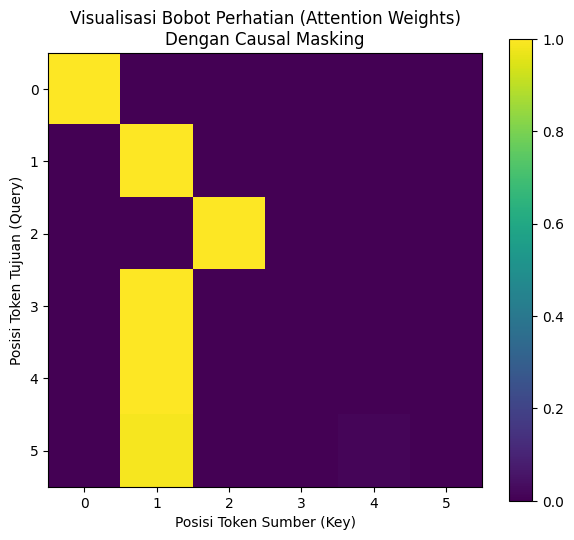

Visualisasi di atas menunjukkan bahwa setiap token (baris) hanya dapat memperhatikan
token pada posisi saat ini dan posisi sebelumnya (kolom).
Area segitiga kanan atas berwarna gelap (nilai 0), membuktikan mask bekerja.


In [52]:
# --- Bonus: Visualisasi Distribusi Attention --- 
# Visualisasi ini secara grafis menunjukkan bukti kerja dari Causal Masking.
# Sumbu-y adalah query (token saat ini) dan sumbu-x adalah key (token yang dilihat).
# Warna terang menunjukkan skor perhatian yang tinggi.

fig, ax = plt.subplots(figsize=(7, 6))
cax = ax.matshow(attention_weights_test, cmap='viridis')
fig.colorbar(cax)

ax.set_title("Visualisasi Bobot Perhatian (Attention Weights)\nDengan Causal Masking")
ax.set_xlabel("Posisi Token Sumber (Key)")
ax.set_ylabel("Posisi Token Tujuan (Query)")
ax.xaxis.set_ticks_position('bottom')

plt.show()

print("Visualisasi di atas menunjukkan bahwa setiap token (baris) hanya dapat memperhatikan")
print("token pada posisi saat ini dan posisi sebelumnya (kolom).")
print("Area segitiga kanan atas berwarna gelap (nilai 0), membuktikan mask bekerja.")

## 3. Simulasi Alur Prediksi Kata Selanjutnya

Sekarang kita akan mensimulasikan bagaimana sebuah model Transformer yang sudah jadi (meskipun bobotnya masih acak) digunakan untuk memprediksi kata.

### Langkah 1: Persiapan Kosakata dan Tokenizer

Setiap model bahasa memiliki kosakata (*vocabulary*) yang terbatas—daftar semua kata yang ia kenali. "Tokenisasi" adalah proses mengubah teks mentah menjadi angka (ID) berdasarkan kosakata ini, dan sebaliknya.

In [53]:
# 1. Definisikan Kosakata (Vocabulary)
# Di dunia nyata, ini bisa berisi 50.000+ kata. Kita akan buat versi mini.
vocabulary = [
    '<pad>', 'aku', 'adalah', 'seorang', 'mahasiswa', 'yang', 'sedang',
    'belajar', 'transformer', 'dari', 'nol', 'di', 'rumah', 'ini', 'tugas'
]

# 2. Buat "Tokenizer"
# Kamus untuk mengubah kata menjadi angka (ID)
word_to_id = {word: i for i, word in enumerate(vocabulary)}

# Kamus untuk mengubah angka (ID) kembali menjadi kata
id_to_word = {i: word for i, word in enumerate(vocabulary)}

# --- Uji Coba Tokenizer ---
kalimat_contoh = "aku adalah seorang mahasiswa"
tokenized_contoh = [word_to_id[word] for word in kalimat_contoh.split()]

print(f"Kalimat Asli: '{kalimat_contoh}'")
print(f"Hasil Tokenisasi (ID): {tokenized_contoh}")

# Simpan ukuran vocab untuk model
vocab_size = len(vocabulary)
print(f"Ukuran Kosakata: {vocab_size} kata")

Kalimat Asli: 'aku adalah seorang mahasiswa'
Hasil Tokenisasi (ID): [1, 2, 3, 4]
Ukuran Kosakata: 15 kata


In [54]:
# Kita gunakan kembali arsitektur GPTDecoder yang sama dari sel sebelumnya.
# Pastikan Anda sudah menjalankan sel yang berisi definisi kelas GPTDecoder.

# Inisialisasi model dengan ukuran vocab yang sudah kita tentukan.
d_model = 64
n_heads = 4
n_layers = 2
d_ff = 128

# PENTING: Ingat, bobot (weights) dalam model ini masih ACAK.
# Model ini belum dilatih sama sekali, jadi prediksinya akan asal-asalan.
# Tujuannya adalah untuk melihat alur prosesnya.
model = GPTDecoder(
    vocab_size=vocab_size,
    d_model=d_model,
    n_layers=n_layers,
    n_heads=n_heads,
    d_ff=d_ff
)

print("Model dengan bobot acak berhasil dibuat.")

Model dengan bobot acak berhasil dibuat.


### Langkah 3: Proses Prediksi Kata Selanjutnya (End-to-End)

Berikut adalah alur lengkap dari input teks hingga output prediksi kata, dengan melihat setiap komponen yang bekerja.

In [55]:
# --- Input Awal ---
input_text = "aku sedang belajar"

# --- A. Komponen Hasil Tokenisasi ---
print(f"1. Input Teks: '{input_text}'")
tokenized_input = [word_to_id[word] for word in input_text.split()]
print(f"2. Hasil Tokenisasi: {tokenized_input}")

# Model memerlukan input dalam bentuk batch, jadi kita tambahkan dimensi baru
# Shape: [1, seq_len]
model_input = np.array([tokenized_input])
print(f"3. Input untuk Model (Batch): {model_input}\n")

# --- B. Menjalankan Model (Forward Pass) ---
# Di sinilah proses Multi-Head Attention, FFN, dll., terjadi.
logits = model.forward(model_input)
print(f"4. Model menghasilkan Logits dengan shape: {logits.shape}")
# Shape: [batch_size, seq_len, vocab_size] -> [1, 3, 15]

# --- C. Mendapatkan Logits untuk Prediksi Berikutnya ---
# Kita hanya tertarik pada output dari token terakhir ("belajar"),
# karena itu yang digunakan untuk memprediksi kata selanjutnya.
last_token_logits = logits[0, -1, :]
print(f"5. Logits dari token terakhir, shape: {last_token_logits.shape}\n")

# --- D. Komponen Hasil Softmax ---
# Mengubah skor logits menjadi distribusi probabilitas yang jumlahnya 1.
probabilities = softmax(last_token_logits)
print("6. Hasil Softmax (Distribusi Probabilitas untuk setiap kata di kosakata):")
# Mencetak probabilitas untuk beberapa kata pertama sebagai contoh
for i in range(len(vocabulary)):
    print(f"   - Kata '{id_to_word[i]}': {probabilities[i]:.4f} ({(probabilities[i]*100):.2f}%)")
print(f"   Jumlah semua probabilitas: {np.sum(probabilities):.2f}\n")


# --- E. Memilih Kata Hasil Prediksi ---
# Kita pilih kata dengan probabilitas tertinggi menggunakan np.argmax
predicted_id = np.argmax(probabilities)
predicted_word = id_to_word[predicted_id]

print(f"7. ID prediksi dengan probabilitas tertinggi: {predicted_id}")
print("---" * 15)
print(f"HASIL PREDIKSI KATA SELANJUTNYA ADALAH: '{predicted_word}'")
print("---" * 15)
print("\n(Ingat: Kata ini hasil dari model yang belum dilatih, jadi hasilnya acak!)")

1. Input Teks: 'aku sedang belajar'
2. Hasil Tokenisasi: [1, 6, 7]
3. Input untuk Model (Batch): [[1 6 7]]

4. Model menghasilkan Logits dengan shape: (1, 3, 15)
5. Logits dari token terakhir, shape: (15,)

6. Hasil Softmax (Distribusi Probabilitas untuk setiap kata di kosakata):
   - Kata '<pad>': 0.0055 (0.55%)
   - Kata 'aku': 0.0000 (0.00%)
   - Kata 'adalah': 0.0038 (0.38%)
   - Kata 'seorang': 0.0000 (0.00%)
   - Kata 'mahasiswa': 0.0000 (0.00%)
   - Kata 'yang': 0.0005 (0.05%)
   - Kata 'sedang': 0.0000 (0.00%)
   - Kata 'belajar': 0.0000 (0.00%)
   - Kata 'transformer': 0.0002 (0.02%)
   - Kata 'dari': 0.0060 (0.60%)
   - Kata 'nol': 0.0001 (0.01%)
   - Kata 'di': 0.0285 (2.85%)
   - Kata 'rumah': 0.0000 (0.00%)
   - Kata 'ini': 0.0000 (0.00%)
   - Kata 'tugas': 0.9555 (95.55%)
   Jumlah semua probabilitas: 1.00

7. ID prediksi dengan probabilitas tertinggi: 14
---------------------------------------------
HASIL PREDIKSI KATA SELANJUTNYA ADALAH: 'tugas'
------------------------

In [56]:
def predict_next_word(text, model):
    """
    Fungsi yang merangkum seluruh proses prediksi.
    """
    # 1. Tokenisasi
    tokenized_input = [word_to_id[word] for word in text.split()]
    model_input = np.array([tokenized_input])
    
    # 2. Forward Pass
    logits = model.forward(model_input)
    
    # 3. Dapatkan Logits & Softmax
    last_token_logits = logits[0, -1, :]
    probabilities = softmax(last_token_logits)
    
    # 4. Prediksi
    predicted_id = np.argmax(probabilities)
    predicted_word = id_to_word[predicted_id]
    
    return predicted_word

# --- Mari kita coba fungsinya ---
prompt1 = "aku adalah"
prediksi1 = predict_next_word(prompt1, model)
print(f"Setelah '{prompt1}', model memprediksi -> '{prediksi1}'")

prompt2 = "transformer dari nol"
prediksi2 = predict_next_word(prompt2, model)
print(f"Setelah '{prompt2}', model memprediksi -> '{prediksi2}'")

prompt3 = "ini tugas"
prediksi3 = predict_next_word(prompt3, model)
print(f"Setelah '{prompt3}', model memprediksi -> '{prediksi3}'")

Setelah 'aku adalah', model memprediksi -> '<pad>'
Setelah 'transformer dari nol', model memprediksi -> '<pad>'
Setelah 'ini tugas', model memprediksi -> 'dari'
